- Core Libs in Transformer
    - Datasets
    - Tokenizer
    - Transformers
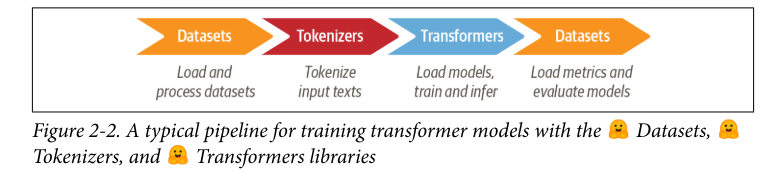

## Dataset
- `from datasets import list_datasets`
- lists available datasets

In [6]:
from datasets import list_datasets

all_datasets = list_datasets()
print(f'the number of datasets: {len(all_datasets)}')

the number of datasets: 139500


## Load a dataset

In [4]:
from datasets import load_dataset

emotions = load_dataset('emotion')
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [9]:
emotions['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [12]:
train_ds = emotions['train']
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [13]:
train_ds.column_names

['text', 'label']

- datasets are based on apache arrow

In [14]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

### Load data files from computer
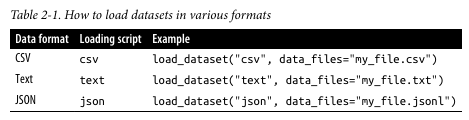

- Load data from a url

In [ ]:
from datasets import load_dataset
dataset_url = "https://www.dropbox.com/s/1pzkadrvffbqw6o/train.txt"
# download the file to disk
!wget {dataset_url}

# load the local file (csv) to notebook
emotions_local = load_dataset(
    "csv", data_files="train.txt", 
    sep=";", names=["text", "label"]
)

## Convert the datasets to dataframes
- .set_format() method used to convert the pyarrow data to pandas
- int2str() method to convert the label(int) to text

In [6]:
import pandas as pd

emotions.set_format(type='pandas')
df = emotions['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [12]:
def label_int2str(row):
    # the dataset featues are a list
    # emotions['train'].features['label']
    return emotions['train'].features['label'].int2str(row)

df['label_name'] = df['label'].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### Class distribution

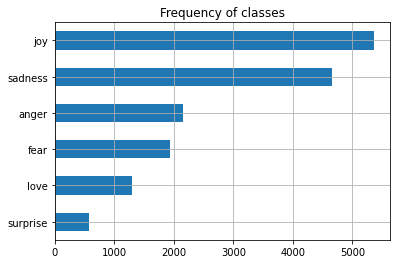

In [18]:
import matplotlib.pyplot as plt

df['label_name'].value_counts(ascending=True).plot.barh()
plt.title('Frequency of classes')
plt.grid()
plt.show()

- address the imbalanced distribution
    - under sample the majority class
    - over sample the majority class
    - gahter more data for minority class
- imbalance learn lib: https://oreil.ly/5XBhb

### Tweet lenghts

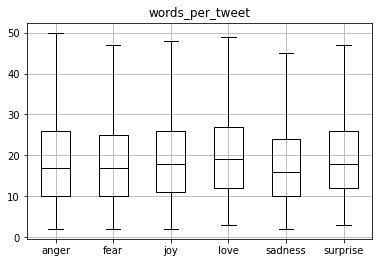

In [26]:
df['words_per_tweet'] = df['text'].apply(lambda x: len(x.split()))
df.boxplot(
    'words_per_tweet', by = 'label_name',
    showfliers=False, color='black'
)
plt.suptitle('')
plt.xlabel('')
plt.show()